In [1]:
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from torchvision import transforms
import os
import sys
os.chdir('../')
sys.path.append('./')
os.getcwd()
from model import DeepJSCC
from stitching import StitchedDeepJSCC, AlignedDeepJSCC
import matplotlib.pyplot as plt
import matplotlib
from utils import get_psnr, image_normalization
import pickle

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

### Eval para

In [3]:
channel = 'AWGN'
model1_fp = r'alignment\models\seed42_v1.pkl'
model2_fp = r'alignment\models\seed43_v1.pkl'
align_fp = r'alignment\models\aligner.pkl'
saved = r'out\checkpoints\CIFAR10_8_7.0_0.17_AWGN_11h35m08s_on_Mar_27_2025\epoch_999.pkl'

snr = 7
test_image_dir = r'demo\0000.jpg'
times = 10

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
test_image = Image.open(test_image_dir)
test_image.load()
test_image = transform(test_image)

### Trans from nn.DataParallel to nn.Module and Load model from checkpoint

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
def load_from_checkpoint(path, snr):
    state_dict = torch.load(path, map_location=torch.device('cpu'))
    from collections import OrderedDict
    new_state_dict = OrderedDict()

    for k, v in state_dict.items():
        name = k.replace('module.','') # remove `module.`
        new_state_dict[name] = v

    file_name = os.path.basename(os.path.dirname(saved))
    c = file_name.split('_')[1]
    c = int(c)
    model = DeepJSCC(c=c, channel_type=channel, snr=snr)

    model.load_state_dict(new_state_dict)
    model.change_channel(channel, snr)

    return model

model1 = load_from_checkpoint(model1_fp, snr)
model2 = load_from_checkpoint(model2_fp, snr)

with open(align_fp, 'rb') as f:
    align_matrix = pickle.load(f)

model = AlignedDeepJSCC(model1, model2, align_matrix)

### Eval for times

average psnr is 23.260086059570312 for 10 times on 0000.jpg


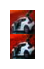

In [15]:
psnr_all = 0.0
with torch.no_grad():

    for i in range(times):
        demo_image = model1(test_image)
        demo_image = image_normalization('denormalization')(demo_image)
        gt = image_normalization('denormalization')(test_image)
        psnr_all += get_psnr(demo_image, gt)
    demo_image = image_normalization('normalization')(demo_image)
    demo_image = torch.cat([test_image, demo_image.squeeze()], dim=1)
    demo_image = demo_image.numpy()

dpi = 100
height, width = demo_image.shape[1], demo_image.shape[2]
figsize = (width / dpi, height / dpi)

fig = plt.figure(figsize=figsize, dpi=dpi)
plt.imshow(demo_image.transpose(1, 2, 0))
plt.axis('off')

print("average psnr is {} for {} times on {}".format( psnr_all.item() / times, times, os.path.basename(test_image_dir)))

average psnr is 25.61907043457031 for 10 times on 0000.jpg


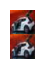

In [16]:
psnr_all = 0.0
with torch.no_grad():

    for i in range(times):
        demo_image = model(test_image)
        demo_image = image_normalization('denormalization')(demo_image)
        gt = image_normalization('denormalization')(test_image)
        psnr_all += get_psnr(demo_image, gt)
    demo_image = image_normalization('normalization')(demo_image)
    demo_image = torch.cat([test_image, demo_image.squeeze()], dim=1)
    demo_image = demo_image.numpy()

dpi = 100
height, width = demo_image.shape[1], demo_image.shape[2]
figsize = (width / dpi, height / dpi)

fig = plt.figure(figsize=figsize, dpi=dpi)
plt.imshow(demo_image.transpose(1, 2, 0))
plt.axis('off')

print("average psnr is {} for {} times on {}".format( psnr_all.item() / times, times, os.path.basename(test_image_dir)))